## Background
In this blog post I'll work through the second exercise of the "Further Research" section in Chapter 9 of the fastai textbook:

> Implement the decision tree algorithm in this chapter from scratch yourself, and try it on the dataset you used in the first exercise.

The decision tree algorithm, as described in the textbook for the Blue Book for Bulldozers Kaggle competition:

1. Loop through each column of the dataset in turn.
2. For each column, loop through each possible level of that column in turn.
3. Try splitting the data into two groups, based on whether they are greater than or less than that value (or if it is a categorical variable, based on whether they are equal to or not equal to that level of that categorical variable).
4. Find the average sale price for each of those two groups, and see how close that is to the actual sale price of each of the items of equipment in that group. Treat this as a very simple "model" in which our predictions are simply the average sale price of the item's group.
5. After looping through all of the columns and all the possible levels for each, pick the split point that gave the best predictions using that simple model.
6. We now have two groups for our data, based on this selected split. Treat each group as a separate dataset, and find the best split for each by going back to step 1 for each group.
7. Continue this process recursively, until you have reached some stopping criterion for each group--for instance, stop splitting a group further when it has only 20 items in it.

I'll implement the algorithm on my own, then compare it with the algorithm Jeremy implemented in the Lesson 6 video, and the `sklearn.DecisionTreeRegressor`.

## Load the Data

I'll follow the same steps as the textbook to load and prepare the training and validation datasets from the Blue Book for Bulldozers Kaggle Competition:

In [ ]:
!pip install dtreeviz

from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

In [ ]:
from pathlib import Path

cred_path = Path("~/.kaggle/kaggle.json").expanduser()
if not cred_path.exists():
  cred_path.parent.mkdir(exist_ok=True)
  cred_path.write_text(creds)
  cred_path.chmod(0o600)

In [ ]:
import zipfile,kaggle

path = Path('bluebook-for-bulldozers')
if not path.exists():
  kaggle.api.competition_download_cli(str(path))
  zipfile.ZipFile(f'{path}.zip').extractall(path)

100%|██████████| 48.4M/48.4M [00:00<00:00, 53.5MB/s]


In [ ]:
path.ls(file_type='text')

(#7) [Path('bluebook-for-bulldozers/Test.csv'),Path('bluebook-for-bulldozers/TrainAndValid.csv'),Path('bluebook-for-bulldozers/random_forest_benchmark_test.csv'),Path('bluebook-for-bulldozers/Machine_Appendix.csv'),Path('bluebook-for-bulldozers/median_benchmark.csv'),Path('bluebook-for-bulldozers/ValidSolution.csv'),Path('bluebook-for-bulldozers/Valid.csv')]

In [ ]:
df = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)

In [ ]:
len(df.columns)

53

In [ ]:
sizes = 'Large', 'Large / Medium', 'Medium', 'Small', 'Mini', 'Compact'
df['ProductSize'] = df['ProductSize'].astype('category')
df['ProductSize'].cat.set_categories(sizes, ordered=True, inplace=True)

<ipython-input-8-37500a139e88>:3: FutureWarning: The `inplace` parameter in pandas.Categorical.set_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.


In [ ]:
dep_var = 'SalePrice'
df[dep_var] = np.log(df[dep_var])

In [ ]:
df = add_datepart(df, 'saledate')
df_test = pd.read_csv(path/'Test.csv', low_memory=False)
df_test = add_datepart(df_test, 'saledate')

In [ ]:
' '.join(o for o in df.columns if o.startswith('sale'))

'saleYear saleMonth saleWeek saleDay saleDayofweek saleDayofyear saleIs_month_end saleIs_month_start saleIs_quarter_end saleIs_quarter_start saleIs_year_end saleIs_year_start saleElapsed'

In [ ]:
procs = [Categorify, FillMissing]

In [ ]:
cond = (df.saleYear<2011) | (df.saleMonth<10)
train_idx = np.where( cond)[0]
valid_idx = np.where(~cond)[0]
splits = (list(train_idx), list(valid_idx))

In [ ]:
cont,cat = cont_cat_split(df, 1, dep_var=dep_var)

In [ ]:
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

In [ ]:
len(to.train), len(to.valid)

(404710, 7988)

In [ ]:
to.show(3)

,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,auctioneerID_na,MachineHoursCurrentMeter_na,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleElapsed,SalePrice
0,Low,521D,521,D,#na#,#na#,#na#,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139246,999089,3157,121,3.0,2004,68.0,2006,11,46,16,3,320,1.163635e+09,11.097410
1,Low,950FII,950,F,II,#na#,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,23.5,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139248,117657,77,121,3.0,1996,4640.0,2004,3,13,26,4,86,1.080259e+09,10.950807
2,High,226,226,#na#,#na#,#na#,#na#,Skid Steer Loader - 1351.0 to 1601.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,#na#,OROPS,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Auxiliary,#na#,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,None or Unspecified,Standard,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,False,False,1139249,434808,7009,121,3.0,2001,2838.0,2004,2,9,26,3,57,1.077754e+09,9.210340


In [3]:
to = load_pickle('to.pkl')

In [4]:
xs,y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

## Decision Tree Algorithm: Before Watching Lesson 6

I haven't watched the Lesson 6 video yet, and am assuming that Jeremy walks through how to build a decision tree from scratch in that video, so I'm trying it out first on my own. To be honest, I'm a bit embarrassed to publish this part of my learning process, since my approach is not very elegant, but I'd like to show what my current thinking is and then compare it with what I understand after learning the formal solution to this algorithm.

I'll start by creating a mean squared error function to calculate at each split:

In [2]:
def mse(pred, y): return ((pred-y)**2).mean()

In [44]:
# root mse and value
mse(y, y.mean()), y.mean()

(0.48205692, 10.104347)

I'll walk through the algorithm step-by-step manually for a couple of columns before I create any functions or loops. The first column in the training dataset's index is the categorical variable `UsageBand` which has a value of `0`, `1`, `2`, or `3`.

In [7]:
xs.columns

Index(['UsageBand', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls',
       'saleIs_month_end', 'saleIs_month_start', 'saleIs_quarter_end',
       'saleIs_quarter_start', 'saleIs_year_end', 'saleIs_year_start',
       'auctioneerID_na', 'MachineHoursCurrentMeter_na', 'SalesID',
       'Mac

In [8]:
xs.UsageBand.unique()

array([2, 1, 3, 0], dtype=int8)

The first split I'll choose is between rows where the `UsageBand` value is `0` or not:

In [9]:
mask = xs.UsageBand == 0
is_zero_xs = xs[mask]
is_zero_y = y[mask]

In [10]:
len(is_zero_xs), len(is_zero_y)

(334164, 334164)

In [11]:
isnt_zero_xs = xs[~mask]
isnt_zero_y = y[~mask]

In [12]:
len(isnt_zero_xs), len(isnt_zero_y)

(70546, 70546)

I'll calculate the average sale price and MSE for each group:

In [13]:
is_zero_y.mean(), mse(is_zero_y, is_zero_y.mean())

(10.080211, 0.46968707)

In [14]:
isnt_zero_y.mean(), mse(isnt_zero_y, isnt_zero_y.mean())

(10.218686, 0.5248172)

I'll put this code into a routine so I can apply it to all splits of `UsageBand`:

In [15]:
def get_cat_splits(xs, y, column):
  splits = []
  for el in xs[column].unique():
    mask = xs[column] == el
    is_el_y = y[mask]
    isnt_el_y = y[~mask]
    is_el_mse = mse(is_el_y, is_el_y.mean())
    isnt_el_mse = mse(isnt_el_y, isnt_el_y.mean())

    split = {
        str(el): is_el_mse,
        "!" + str(el): isnt_el_mse
    }

    splits.append(split)
  return splits

In [16]:
splits = get_cat_splits(xs, y, "UsageBand")
splits

[{'2': 0.46612886, '!2': 0.4824535},
 {'1': 0.5223263, '!1': 0.476563},
 {'3': 0.50998193, '!3': 0.47640917},
 {'0': 0.46968707, '!0': 0.5248172}]

Great! My function calculates the MSE for each split in a categorical column. However, I don't need to store all of the splits for the column, just the best one (the one with the lowest MSE). I'll modify my function so that it returns only the best split:

In [7]:
def get_cat_best_split(xs, y, column):
  best_split = []
  lowest_mse = 1000000

  for el in xs[column].unique():
    mask = xs[column] == el

    # ignore splits where either group has 0 or 1 row
    if sum(mask) == 0: continue
    if sum(mask) == 1: continue
    if sum(~mask) == 1: continue

    is_el_y = y[mask]
    isnt_el_y = y[~mask]

    is_el_mse = mse(is_el_y, is_el_y.mean())
    isnt_el_mse = mse(isnt_el_y, isnt_el_y.mean())

    if is_el_mse < lowest_mse or isnt_el_mse < lowest_mse:
      best_split = [el, [is_el_mse, isnt_el_mse]]

    lowest_mse = min(is_el_mse, isnt_el_mse, lowest_mse)
  print(column)
  return best_split

In [18]:
get_cat_best_split(xs, y, "UsageBand")

UsageBand


[2, [0.46612886, 0.4824535]]

I now have the category for which the split was made (is 2, isn't 2) and the corresponding MSE.

Next, I'll find the best split for one of the continuous columns, `YearMade`:

In [19]:
xs.YearMade.unique()

array([2004, 1996, 2001, 2007, 1993, 2008, 1000, 1998, 1999, 2003, 1991,
       2000, 2005, 1995, 2006, 2002, 1984, 1988, 1980, 1992, 1987, 1997,
       1971, 1978, 1989, 1985, 1979, 1976, 1994, 1982, 1990, 1974, 1968,
       1966, 1983, 1986, 1981, 1970, 1977, 1975, 1973, 1965, 1967, 2009,
       2010, 1969, 1972, 1964, 1957, 1958, 1963, 1919, 1920, 1950, 1948,
       1952, 1942, 1956, 1954, 1953, 1955, 1959, 1960, 1961, 1962, 1951,
       1937, 1949, 1947, 2012, 2011, 2014], dtype=int16)

In [20]:
mask = xs.YearMade <= 2004
lte_2004_xs = xs[mask]
lte_2004_y = y[mask]

In [21]:
len(lte_2004_xs), len(lte_2004_y)

(364685, 364685)

In [22]:
gt_2004_xs = xs[~mask]
gt_2004_y = y[~mask]

In [23]:
len(gt_2004_xs), len(gt_2004_y)

(40025, 40025)

So far the process is pretty similar to what I did for categorical variables. I'll calculate the average sale price and MSE for each split next:

In [24]:
lte_2004_y.mean(), mse(lte_2004_y, lte_2004_y.mean())

(10.072348, 0.46514994)

In [25]:
gt_2004_y.mean(), mse(gt_2004_y, gt_2004_y.mean())

(10.395911, 0.5417633)

Great! I'll wrap this process into a function:

In [12]:
def get_cont_best_split(xs, y, column):
  best_split = []
  lowest_mse = 1000000

  for el in xs[column].unique():
    mask = xs[column] <= el

    # ignore splits where either group has 0 or 1 row
    if sum(mask) == 0: continue
    if sum(mask) == 1: continue
    if sum(~mask) == 1: continue

    lte_el_y = y[mask]
    gt_el_y = y[~mask]

    lte_el_mse = mse(lte_el_y, lte_el_y.mean())
    gt_el_mse = mse(gt_el_y, gt_el_y.mean())

    if lte_el_mse < lowest_mse or gt_el_mse < lowest_mse:
      best_split = [el, [lte_el_mse, gt_el_mse]]

    lowest_mse = min(lte_el_mse, gt_el_mse, lowest_mse)
  print(column)
  return best_split



In [27]:
get_cont_best_split(xs, y, "YearMade")

YearMade


[2012, [0.4820588, 0.00022279842]]

Now that I have functions to calculate the best split (by MSE) for categorical and continuous variables, I can loop through each column, apply these functions and then determine the overall best split. I'll use a small dataset for this procedure since the loops require too much time (more than an hour) when I use the full dataset:

In [28]:
xs_sub = xs.sample(1000, random_state=42)
y_sub = y[xs_sub.index]

In [ ]:
best_splits = []
for column in xs_sub.columns:
  if column in to.cat_names:
    best_splits.append([column, get_cat_best_split(xs_sub, y_sub, column)])
  if column in to.cont_names:
    best_splits.append([column, get_cont_best_split(xs_sub, y_sub, column)])

In [30]:
best_splits

[['UsageBand', [0, [0.4289803, 0.5418442]]],
 ['fiModelDesc', [1082, [0.0, 0.45956165]]],
 ['fiBaseModel', [72, [0.0, 0.45933586]]],
 ['fiSecondaryDesc', [139, [0.0010413192, 0.45947686]]],
 ['fiModelSeries', [22, [0.0018927432, 0.45957345]]],
 ['fiModelDescriptor', [138, [0.0011120219, 0.45861065]]],
 ['ProductSize', [6, [0.17651369, 0.45974725]]],
 ['fiProductClassDesc', [59, [0.0028960933, 0.4587686]]],
 ['state', [15, [0.024394397, 0.45930827]]],
 ['ProductGroup', [3, [0.10852089, 0.39364752]]],
 ['ProductGroupDesc', [3, [0.10852089, 0.39364752]]],
 ['Drive_System', [2, [0.0733325, 0.49420977]]],
 ['Enclosure', [3, [0.30207962, 0.37955183]]],
 ['Forks', [2, [0.28580874, 0.4628031]]],
 ['Pad_Type', [4, [0.01935081, 0.46220613]]],
 ['Ride_Control', [1, [0.10788533, 0.53090215]]],
 ['Stick', [1, [0.08875317, 0.49070317]]],
 ['Transmission', [3, [0.037590597, 0.4595029]]],
 ['Turbocharged', [2, [0.043661047, 0.46277064]]],
 ['Blade_Extension', [1, [0.6090261, 0.43294448]]],
 ['Blade_Wi

In [33]:
lowest_mse = 10000
for split in best_splits:
  if len(split[1]) > 0:
    if min(split[1][1]) < lowest_mse:
      lowest_mse = min(split[1][1])
      best_split_column = split[0]
      best_split_value = split[1][0]
best_split_column, lowest_mse, best_split_value

('fiModelDesc', 0.0, 1082)

There were numerous splits with an MSE of `0.0` so I'll just pick the first one which is for when `fiModelDesc` is 1082.

In [34]:
mask = xs_sub.fiModelDesc == best_split_value
left_xs = xs_sub[mask]
right_xs = xs_sub[~mask]

left_y = y_sub[mask]
right_y = y_sub[~mask]

len(left_xs), len(right_xs)

(2, 998)

In [37]:
left_y.mean(), right_y.mean()

(9.998797, 10.110093)

In [36]:
mse(left_y, left_y.mean()), mse(right_y, right_y.mean())

(0.0, 0.45956165)

In [38]:
left_xs

,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,...,saleDay,saleDayofweek,saleDayofyear,saleElapsed
292246,0,1082,326,93,...,25,2,84,1.237939e+09
292242,0,1082,326,93,...,25,2,84,1.237939e+09


I'll leave the `left_xs` split as a leaf, since it has only two values. I'll continue to split `right_xs`:

In [ ]:
best_splits = []
for column in right_xs.columns:
  if column in to.cat_names and column != 'fiModelDesc':
    best_splits.append([column, get_cat_best_split(right_xs, right_y, column)])
  if column in to.cont_names:
    best_splits.append([column, get_cont_best_split(right_xs, right_y, column)])

In [40]:
lowest_mse = 10000
for split in best_splits:
  if len(split[1]) > 0:
    if min(split[1][1]) < lowest_mse:
      lowest_mse = min(split[1][1])
      best_split_column = split[0]
      best_split_value = split[1][0]
best_split_column, lowest_mse, best_split_value

('fiBaseModel', 0.0, 72)

The next best split is for `fiBaseModel`:

In [41]:
mask = right_xs.fiBaseModel == best_split_value
left_xs = right_xs[mask]
right_xs = right_xs[~mask]

left_y = right_y[mask]
right_y = right_y[~mask]

len(left_xs), len(right_xs)

(2, 996)

In [102]:
left_xs

,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,...,saleDay,saleDayofweek,saleDayofyear,saleElapsed
372510,0,1030,313,50,...,17,2,321,1.289952e+09
366529,0,2214,698,31,...,12,1,102,1.302566e+09


In [42]:
left_y.mean(), right_y.mean()

(10.463103, 10.109385)

In [43]:
mse(left_y, left_y.mean()), mse(right_y, right_y.mean())

(0.0, 0.4602337)

Again, one of the splits only has two values, so I'll keep that as the second leaf, and continue to split the other group:

In [ ]:
best_splits = []
for column in right_xs.columns:
  if column in to.cat_names and column not in ['fiModelDesc', 'fiBaseModel']:
    best_splits.append([column, get_cat_best_split(right_xs, right_y, column)])
  if column in to.cont_names:
    best_splits.append([column, get_cont_best_split(right_xs, right_y, column)])

In [47]:
lowest_mse = 10000
for split in best_splits:
  if len(split[1]) > 0:
    if min(split[1][1]) < lowest_mse:
      lowest_mse = min(split[1][1])
      best_split_column = split[0]
      best_split_value = split[1][0]
best_split_column, lowest_mse, best_split_value

('saleElapsed', 0.0004528304, 607910400.0)

The final split (to reach four leaf nodes like the textbook) is on `saleElapsed`.

In [49]:
mask = right_xs.saleElapsed <= best_split_value
left_xs = right_xs[mask]
right_xs = right_xs[~mask]

left_y = right_y[mask]
right_y = right_y[~mask]

mse(left_y, left_y.mean()), mse(right_y, right_y.mean())

(0.0004528304, 0.4609359)

In [50]:
left_y.mean(), right_y.mean()

(9.776848, 10.110054)

In [51]:
len(left_xs), len(right_xs)

(2, 994)

Plotting the decision tree (manually) to visualize the splits:

![My Decision Tree Algorithm](my_decision_tree.svg)

My model seems to be making incremental splits (with 2 rows taken off each split) based on very small sample sizes. One question I have is if the decision tree is always supposed to select the minimum or is it choosing randomly one of the many columns with relatively small MSE values? Another question: am I supposed to exclude a column from future splits once a split has been made on the column (which is what I'm doing currently)? I'll be looking for these answers when watching the Lesson 6 video.

## Decision Tree Algorithm: After Watching Lesson 6

The algorithm presented in the [Lesson 6 video ](https://www.youtube.com/watch?v=AdhG64NF76E)(from Jeremy's notebook [How random forests really work](https://www.kaggle.com/code/jhoward/how-random-forests-really-work)) evaluates a split based on a weighted standard deviation calculation.

For a given condition (for example `Age <= 6`) Jeremy calculates the following:

- A "side score" which is the product of the standard deviation of the dependent variable and number of rows for rows that satisfy the condition.
- A side score for the rows that **don't** satisfy the condition.
- The sum of both side scores divided by the number of total rows in the dependent variable column.


Then for each column, he calculates the side score for splits at each unique value of the column and gets the minimum score (and corresponding split value). The column (and corresponding value) with the split that has the smallest score is determined as the best split.

Conceptually: the column (and value) where the weighted standard deviation is the smallest is the column where a split on that value will create two groups where within each group there will be dependent variable values that are relatively close to each other.


I'll start by coding the `_side_score` function Jeremy defined, which calculates the product of the standard deviation of the dependent variable and number of rows in the give split side:

In [1]:
def _side_score(side, y):
    tot = side.sum()
    if tot<=1: return 0
    return y[side].std()*tot

Next, the function `score` which calculates the sum of each side's `_side_score` divided by the total number of rows, or in other words, the weighted average of each side's standard deviation:

In [2]:
def score(col, y, split):
    lhs = col<=split
    return (_side_score(lhs,y) + _side_score(~lhs,y))/len(y)

I'll reload the data so and take the same subset as above so I can compare the splits this algorithm makes to the ones made previously:

In [3]:
to = load_pickle("to.pkl")

In [4]:
xs,y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

In [5]:
xs_sub = xs.sample(1000, random_state=42)
y_sub = y[xs_sub.index]

In [7]:
mse(y_sub, y_sub.mean()), y_sub.mean()

(0.45866725, 10.109871)

In [58]:
score(xs['UsageBand'], y, 2)

0.6922498415264088

I'll walk through each step of the score calculation manually to visualize it better.

First we create a boolean array of rows that satisfy or don't satisfy the condition:

In [59]:
lhs = xs['UsageBand'] <= 2

In [60]:
lhs

0          True
1          True
2          True
3          True
4         False
          ...  
412693     True
412694     True
412695     True
412696     True
412697     True
Name: UsageBand, Length: 404710, dtype: bool

Next: for how many columns is the condition met?

In [61]:
tot = lhs.sum()
tot

370444

What is the standard deviation of the dependent variable for rows where the condition is met?

In [62]:
y[lhs].std()

0.69022495

Finally, what is the side score for this condition?

In [63]:
side_score_lhs = y[lhs].std()*tot
side_score_lhs

255689.68972754478

We ask the same questions for the rows where the condition is NOT met:

In [64]:
tot = (~lhs).sum()
tot

34266

In [65]:
y[~lhs].std()

0.71414065

In [66]:
side_score_rhs = y[~lhs].std()*tot
side_score_rhs

24470.743636608124

Finally, we add the two side scores together and divide by the number of total rows:

In [67]:
(side_score_lhs + side_score_rhs) / len(y)

0.6922498415264088

Thankfully, this is equal to the output from the function `_side_score`! I'll continue by getting the code for calculating this score for splits on each of the unique values in a column:

In [68]:
def min_col(xs, nm, y):
    col = xs[nm]
    unq = col.dropna().unique()
    scores = np.array([score(col, y, o) for o in unq if not np.isnan(o)])
    idx = scores.argmin()
    return unq[idx],scores[idx]

Let's test it out on `UsageBand`:

In [69]:
min_col(xs, 'UsageBand', y)

(0, 0.6921555579861831)

Again, I'll go line-by-line through the code of `min_col` to make sure I understand what's going on:

In [70]:
col = xs['UsageBand']
col

0         2
1         2
2         1
3         1
4         3
         ..
412693    0
412694    0
412695    0
412696    0
412697    0
Name: UsageBand, Length: 404710, dtype: int8

What are the unique values in this column?

In [71]:
unq = col.dropna().unique()
unq

array([2, 1, 3, 0], dtype=int8)

If we split the data on each of the unique values, what is the score for each split?

In [72]:
scores = np.array([score(col, y, o) for o in unq if not np.isnan(o)])
scores

array([0.69224984, 0.69378292, 0.69430405, 0.69215556])

What is the minimum score, and what value does it correspond to?

In [73]:
idx = scores.argmin()
idx

3

In [74]:
unq[idx], scores[idx]

(0, 0.6921555579861831)

Next, I'll iterate through all of the columns in the data and calculate the minimum score (and corresponding value) for each one. I'll use the smaller subset of the data since the list comprehension was taking more than an hour to compute on the full dataset.

In [75]:
col_scores = {o: min_col(xs_sub, o, y_sub) for o in xs_sub.columns}

In [76]:
col_scores

{'UsageBand': (0, 0.6710787683725357),
 'fiModelDesc': (150, 0.6684566705226899),
 'fiBaseModel': (30, 0.66775039935112),
 'fiSecondaryDesc': (15, 0.6461849688887596),
 'fiModelSeries': (60, 0.6612360656261445),
 'fiModelDescriptor': (9, 0.6385975532531738),
 'ProductSize': (0, 0.649804151058197),
 'fiProductClassDesc': (7, 0.6468342208862304),
 'state': (52, 0.6769107410311699),
 'ProductGroup': (3, 0.6413102557659149),
 'ProductGroupDesc': (3, 0.6413102557659149),
 'Drive_System': (3, 0.6595019570589066),
 'Enclosure': (3, 0.6443507042527199),
 'Forks': (0, 0.6468727025985718),
 'Pad_Type': (0, 0.6484307520389557),
 'Ride_Control': (0, 0.6693848296999931),
 'Stick': (0, 0.6484307520389557),
 'Transmission': (6, 0.6698495596647263),
 'Turbocharged': (0, 0.6484307520389557),
 'Blade_Extension': (0, 0.6660390158891678),
 'Blade_Width': (2, 0.665115752696991),
 'Enclosure_Type': (0, 0.6660390158891678),
 'Engine_Horsepower': (0, 0.6660390158891678),
 'Hydraulics': (0, 0.6497658799290658)

I'll then find the split across all columns with the lowest score:

In [77]:
min_col_score = min(col_scores.values())
min_col_names = [key for key in col_scores if col_scores[key] == min_col_score]

In [78]:
min_col_score, min_col_names

((0, 0.5992864975929261),
 ['Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow'])

The lowest score was around the split of `<=0` for three columns, which interestingly enough, were found to be redundant features in the textbook chapter. I'll pick `Coupler_System` since that's the split used in the textbook.

In [79]:
xs_sub.Coupler_System.unique()

array([0, 1, 2], dtype=int8)

To answer one of my earlier questions, I think we only remove a column from future splits if it was a binary column (such as the `Sex` column was in the Titanic dataset) since there are only two possible groups and once the data has been split into those two groups, there's nothing left to split in that column.



In [80]:
mask = xs_sub.Coupler_System <= 0
lhs = xs_sub[mask]
rhs = xs_sub[~mask]

lhs_y = y_sub[mask]
rhs_y = y_sub[~mask]

len(lhs), len(rhs)

(904, 96)

In [81]:
lhs_y.mean(), rhs_y.mean()

(10.208925, 9.177121)

In [82]:
mse(lhs_y, lhs_y.mean()), mse(rhs_y, rhs_y.mean())

(0.39364752, 0.10852089)

The lefthand-side has many more rows so I'll continue splitting that dataset and keep `rhs` as a leaf node.

`Coupler_System` only has one value, `0`, in this group so I'll remove it from future splits.

In [83]:
lhs.Coupler_System.unique()

array([0], dtype=int8)

In [84]:
lhs = lhs.drop("Coupler_System", axis=1)

In [85]:
'Coupler_System' in lhs.columns

False

In [86]:
col_scores = {o: min_col(lhs, o, lhs_y) for o in lhs.columns}
min_col_score = min(col_scores.values())
min_col_names = [key for key in col_scores if col_scores[key] == min_col_score]
min_col_score, min_col_names

((0, 0.5869915567140663), ['Pad_Type', 'Stick', 'Turbocharged'])

Again we have three columns with the same split score. I'll choose `Pad_Type` as the column to split on.

In [87]:
lhs.Pad_Type.unique()

array([2, 0, 3, 4], dtype=int8)

In [88]:
mask = lhs.Pad_Type <= 0
rhs = lhs[~mask]
lhs = lhs[mask]

rhs_y = lhs_y[~mask]
lhs_y = lhs_y[mask]

len(lhs), len(rhs)

(700, 204)

In [89]:
lhs_y.mean(), rhs_y.mean()

(10.30318, 9.885499)

In [90]:
mse(lhs_y, lhs_y.mean()), mse(rhs_y, rhs_y.mean())

(0.43736917, 0.108533934)

Again, the lefthand-side has more rows so I'll continue to split it. I'll keep `rhs` as the second leaf node. I'll also remove `Pad_Type` from `lhs` since it has a single value of `0`.

In [91]:
lhs = lhs.drop("Pad_Type", axis=1)

In [92]:
'Pad_Type' in lhs.columns

False

In [93]:
col_scores = {o: min_col(lhs, o, lhs_y) for o in lhs.columns}
min_col_score = min(col_scores.values())
min_col_names = [key for key in col_scores if col_scores[key] == min_col_score]
min_col_score, min_col_names

((0, 0.6552193513938359),
 ['Drive_System',
  'Blade_Extension',
  'Enclosure_Type',
  'Engine_Horsepower',
  'Scarifier',
  'Tip_Control'])

I now have six columns that have the same split score. I'll choose the first one, `Drive_System` to make my final split and get my last two leaf nodes.

In [94]:
mask = lhs.Drive_System <= 0
rhs = lhs[~mask]
lhs = lhs[mask]

rhs_y = lhs_y[~mask]
lhs_y = lhs_y[mask]

len(lhs), len(rhs)

(638, 62)

In [95]:
lhs_y.mean(), rhs_y.mean()

(10.275307, 10.590003)

In [96]:
mse(lhs_y, lhs_y.mean()), mse(rhs_y, rhs_y.mean())

(0.41287065, 0.59920347)

Here is a manually made visualization of this four-leaf-node decision tree:

![Jeremy's Decision Tree](jeremy_decision_tree.svg)

## Decision Tree Algorithm: Using sklearn

The last decision tree that I'll create for comparison with the other two approaches.

In [25]:
m = DecisionTreeRegressor(max_leaf_nodes=4).fit(xs_sub, y_sub);

In [26]:
from sklearn.tree import export_graphviz

import graphviz

def draw_tree(t, df, size=10, ratio=0.6, precision=2, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))

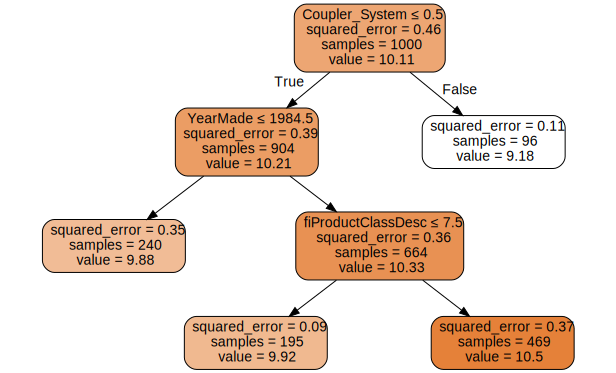

In [27]:
draw_tree(m, xs_sub, size=10)

## Final Thoughts

In this exercise, I tried three different algorithms to create a four-leaf-node decision tree on a 1000-sample subset of the Blue Book for Bulldozer's Kaggle competition dataset:

- An algorithm I created where the model made splits based on the lowest MSE.
- Jeremy's "side score" algorithm which found the split with the lowest weighted standard deviation.
- `sklearn.DecisionTreeRegressor` which also uses MSE to decide splits.

![Decision Tree Comparison](decision_tree_comparison.svg)

Here are some key observations:

- My algorithm made splits with very small samples. To improve this, I would either explicitly ignore splits with low samples or penalize such splits by weighting by number of rows like Jeremy did in `_side_score`.
- The `sklearn.DecisionTreeRegressor` had the same initial split as Jeremy's (on `Coupler_System`) but then chose two completely different columns to split on for the remainder of the leaf nodes. I wonder if this difference in column selection is due to the difference in how a split is scored between those two algorithms.
- A future improvement I could make to this experiment is compare the MSE on a validation set for each decision tree.
- Another future improvement would be to make my algorithm and Jeremy's algorithm run faster so that I can test it on the actual dataset in a reasonable amount of time.

This was another challenging and enjoyable "Further Research" exercise provided by the fastai textbook. I hope you enjoyed this blog post!